In [128]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from shapely.geometry import Point, LineString
from shapely.ops import transform
from shapely import offset_curve
import scipy
import hdbscan
import os
from dotenv import load_dotenv
import requests

%matplotlib inline

Download Capital Ring route buffer
The route and the buffer was done in QGIS
The buffer is 1000m, and allows to capture the POI in the areas along the route

In [2]:
#capital_ring_buffer = gpd.read_file('data/capital_ring_buffer.geojson')
#capital_ring_buffer.plot()

In [8]:
boro_shp = "data/source/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
boro_gdf = gpd.read_file(boro_shp).to_crs('EPSG:27700')
boro_gdf.tail()

city_of_london_boro = (boro_gdf[boro_gdf['NAME'] == 'City of London'])

<Axes: >

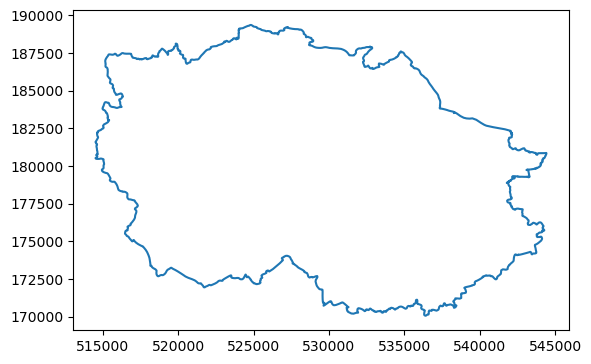

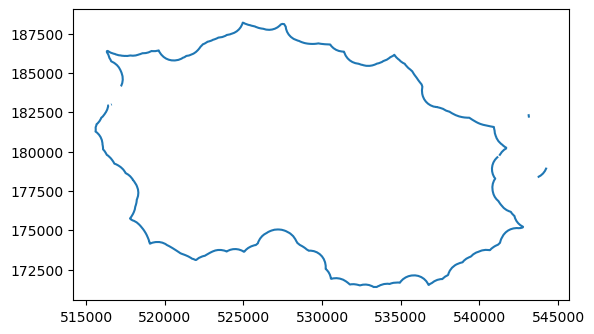

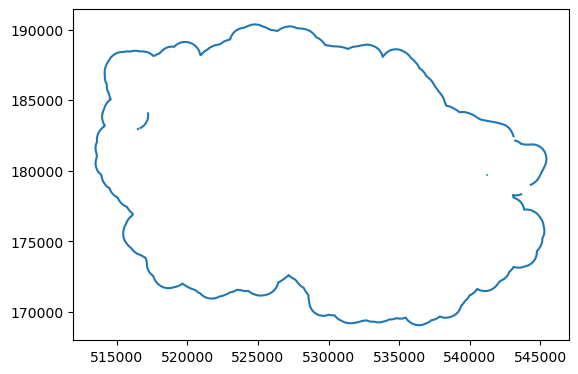

In [27]:
capital_ring_line = gpd.read_file('data/CR_reproject_smooth.geojson')
capital_ring_line.plot()

# Define offset distances
offset_distance_outside = 1000   # Positive value offsets to the left (outside)
offset_distance_inside = -1000   # Negative value offsets to the right (inside)

# Function to offset geometries
def apply_offset(geom, distance):
    if isinstance(geom, LineString):
        return offset_curve(geom, distance)
    return geom  # Return unchanged for other geometries

# Create new GeoDataFrames for inside and outside offsets
capital_ring_line_outside = capital_ring_line.copy()
capital_ring_line_outside["geometry"] = capital_ring_line["geometry"].apply(lambda geom: apply_offset(geom, offset_distance_outside))

capital_ring_line_inside = capital_ring_line.copy()
capital_ring_line_inside["geometry"] = capital_ring_line["geometry"].apply(lambda geom: apply_offset(geom, offset_distance_inside))


In [30]:
line = [capital_ring_line.iloc[0].geometry,
        capital_ring_line_outside.iloc[0].geometry,
        capital_ring_line_inside.iloc[0].geometry]  # Extract the LineString geometry

sampled_points = []
for l in line:
    interval = 500
    distances = range(0, int(l.length), interval)
    sampled_points.extend([l.interpolate(d) for d in distances])

capital_ring_line_sampled_points = gpd.GeoDataFrame(geometry=sampled_points, crs=capital_ring_line.crs)

/tmp/ipykernel_136/891606438.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


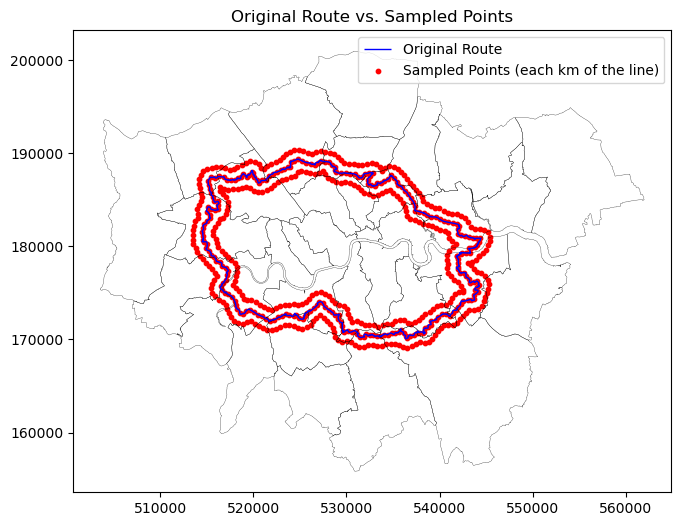

In [32]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(10, 6))
capital_ring_line.plot(ax=ax, color='blue', linewidth=1, label="Original Route")
capital_ring_line_sampled_points.plot(ax=ax, color='red', markersize=10, label="Sampled Points (each km of the line)")
boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Sampled Points")
plt.show()

In [33]:
capital_ring_line_sampled_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  596 non-null    geometry
dtypes: geometry(1)
memory usage: 4.8 KB


In [178]:
# Load environment variables from the .env file
load_dotenv()
# Access the API key, secret key, and endpoint from environment variables
os_key = os.getenv('OS_API_KEY')
os_api_endpoint = 'https://api.os.uk/search/names/v1/nearest'

fq = 'LOCAL_TYPE:Hamlet LOCAL_TYPE:Suburban_Area LOCAL_TYPE:Village LOCAL_TYPE:Town LOCAL_TYPE:Other_Settlement' #which types of places to include
radius = 1000
point = "placeholder"

#print("Full URL:", OS_placenames_url)

In [179]:
places_df = pd.DataFrame()

In [180]:
for i in capital_ring_line_sampled_points['geometry']:
    sampled_point_string = (f"{i.x:.2f},{i.y:.2f}")
    point = sampled_point_string
    os_placenames_url = f"{os_api_endpoint}?point={point}&radius={radius}&fq={fq}&key={os_key}"

    os_response = requests.get(os_placenames_url)

    if os_response.status_code == 200:
        data = os_response.json()
        results = data.get('results', [])
    
        if results:
            df = pd.json_normalize(results)
            places_df = pd.concat([places_df, df], ignore_index=True)
        else:
            print("No results found for point:", point)
    else:
        print(f"Error: {os_response.status_code} - {os_response.text}")

No results found for point: 532439.95,187880.36
No results found for point: 524000.28,189016.34
No results found for point: 523994.01,188543.48
No results found for point: 521390.53,187155.29
No results found for point: 520923.09,187066.72
No results found for point: 520573.50,186791.69
No results found for point: 520350.71,187146.30
No results found for point: 519521.04,187649.10
No results found for point: 518944.17,187782.46
No results found for point: 516337.33,187494.40
No results found for point: 515790.45,184875.47
No results found for point: 516176.41,184458.29
No results found for point: 515901.31,183863.73
No results found for point: 515452.65,184037.82
No results found for point: 515104.00,184178.20
No results found for point: 515039.72,183734.96
No results found for point: 515313.73,183360.29
No results found for point: 515367.71,182998.38
No results found for point: 514604.32,181090.24
No results found for point: 515470.40,179115.74
No results found for point: 515832.95,17

In [192]:
places_df['geometry'] = places_df.apply(lambda row: Point(row['GAZETTEER_ENTRY.GEOMETRY_X'], row['GAZETTEER_ENTRY.GEOMETRY_Y']), axis=1)
places_gdf = gpd.GeoDataFrame(places_df, geometry='geometry')

#There are some duplicated entries
places_gdf = places_gdf.drop_duplicates(subset=['geometry'], keep='first')
print(f"Found {len(places_gdf)} places.")

# Drop unnecessary columns to reduce file size
columns_to_drop = [
    'GAZETTEER_ENTRY.ID', 'GAZETTEER_ENTRY.NAMES_URI', "GAZETTEER_ENTRY.TYPE", "GAZETTEER_ENTRY.LOCAL_TYPE",
    "GAZETTEER_ENTRY.GEOMETRY_X", "GAZETTEER_ENTRY.GEOMETRY_Y", "GAZETTEER_ENTRY.MBR_XMIN",
    "GAZETTEER_ENTRY.COUNTY_UNITARY", "GAZETTEER_ENTRY.COUNTY_UNITARY_URI", "GAZETTEER_ENTRY.COUNTY_UNITARY_TYPE",
    "GAZETTEER_ENTRY.REGION", "GAZETTEER_ENTRY.REGION_URI", "GAZETTEER_ENTRY.COUNTRY",
    "GAZETTEER_ENTRY.COUNTRY_URI", "GAZETTEER_ENTRY.SAME_AS_GEONAMES", "GAZETTEER_ENTRY.MBR_XMAX", "GAZETTEER_ENTRY.MBR_YMAX", "GAZETTEER_ENTRY.POSTCODE_DISTRICT", 
    "GAZETTEER_ENTRY.POSTCODE_DISTRICT_URI", "GAZETTEER_ENTRY.DISTRICT_BOROUGH", "GAZETTEER_ENTRY.DISTRICT_BOROUGH_URI", "GAZETTEER_ENTRY.DISTRICT_BOROUGH_TYPE", "GAZETTEER_ENTRY.MBR_YMIN"
]
places_gdf.drop(columns=columns_to_drop, inplace=True)

Found 154 places.


In [193]:
places_gdf.head()

,GAZETTEER_ENTRY.NAME1,GAZETTEER_ENTRY.MOST_DETAIL_VIEW_RES,GAZETTEER_ENTRY.LEAST_DETAIL_VIEW_RES,GAZETTEER_ENTRY.SAME_AS_DBPEDIA,geometry
0,North Woolwich,12000,25000,http://dbpedia.org/resource/North_Woolwich,POINT (543058 179748)
1,Royal Arsenal West,5000,25000,NaN,POINT (544046 179138)
2,Cavendish Square,15000,25000,NaN,POINT (544260 180702)
6,Cyprus,4000,25000,NaN,POINT (543493 180920)
8,Beckton,20000,25000,http://dbpedia.org/resource/Beckton,POINT (542951 181665)


In [194]:
places_gdf["GAZETTEER_ENTRY.MOST_DETAIL_VIEW_RES"].value_counts()
only_biggest_places = places_gdf[places_gdf["GAZETTEER_ENTRY.MOST_DETAIL_VIEW_RES"] >= 16000].copy()
only_smallest_places = places_gdf[places_gdf["GAZETTEER_ENTRY.MOST_DETAIL_VIEW_RES"] <= 16000].copy()

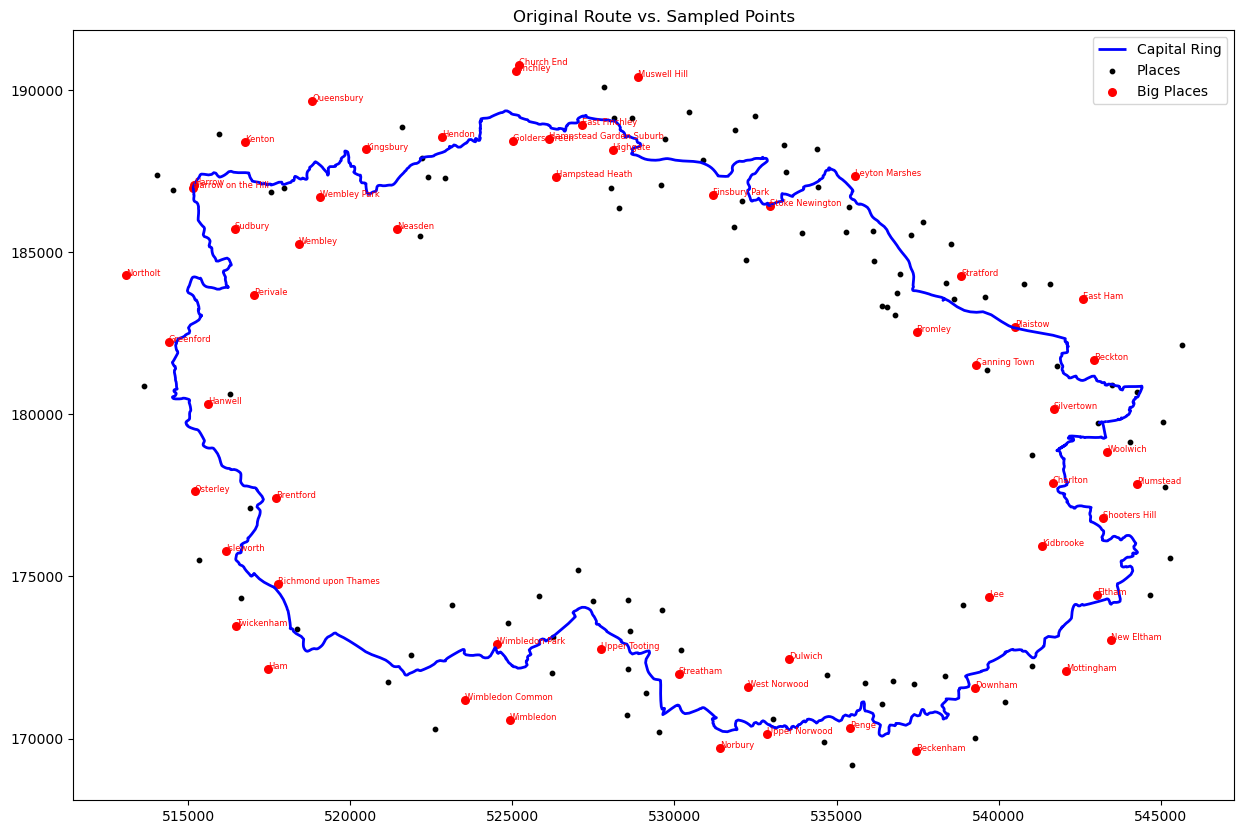

In [195]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(20, 10))
capital_ring_line.plot(ax=ax, color='blue', linewidth=2, label="Capital Ring")
only_smallest_places.plot(ax=ax, color='black', markersize=10, label="Places")
only_biggest_places.plot(ax=ax, color='red', markersize=30, label="Big Places")

# Add labels using apply (avoiding explicit for-loop)
only_biggest_places.apply(lambda row: ax.text(
    row.geometry.x, row.geometry.y, row["GAZETTEER_ENTRY.NAME1"], 
    fontsize=6, color='red'
    # ha='right', va='bottom' 
    # bbox=dict(facecolor='white', edgecolor='red', alpha=0.7
), axis=1)

# Add labels using apply (avoiding explicit for-loop)
# only_smallest_places.apply(lambda row: ax.text(
#     row.geometry.x, row.geometry.y, row["GAZETTEER_ENTRY.NAME1"], 
#     fontsize=6, color='black'
#     # ha='right', va='bottom' 
#     # bbox=dict(facecolor='white', edgecolor='red', alpha=0.7
# ), axis=1)

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Sampled Points")
plt.show()

In [196]:
drop_list = ["Church End", "Harrow on the Hill", "Lee", "Wimbledon Common", "Wimbledon Park"]
for index, row in only_biggest_places.iterrows():
    if row["GAZETTEER_ENTRY.NAME1"] in drop_list:
        only_biggest_places.drop(index, inplace=True)

In [197]:
places_gdf = only_biggest_places

/tmp/ipykernel_136/3585290458.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


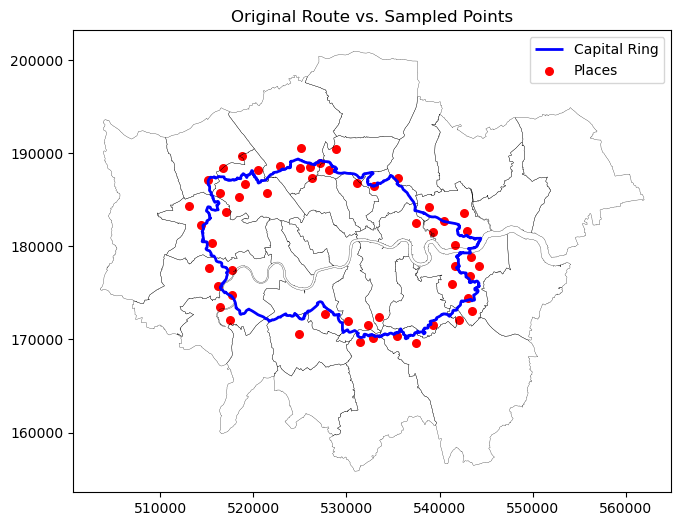

In [198]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(10, 6))
capital_ring_line.plot(ax=ax, color='blue', linewidth=2, label="Capital Ring")
places_gdf.plot(ax=ax, color='red', markersize=30, label="Places")
boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Sampled Points")
plt.show()

In [199]:
print(places_gdf.iloc[2]["geometry"])
places_gdf.set_crs('EPSG:27700', inplace=True)
print(places_gdf.crs)

POINT (535562 187349)
EPSG:27700


In [200]:
#Setting params for Wikipedia API
wiki_api_endpoint = 'https://en.wikipedia.org/w/api.php?action=query&list=geosearch'
radius = 1000

#Reprojecting gdf to fit the API requirements
places_gdf_wgs84 = places_gdf.to_crs(4258)
print(places_gdf_wgs84.crs)
print(places_gdf_wgs84.iloc[2]["geometry"]) #ensuring the coordinates have transformed

EPSG:4258
POINT (-0.045412275836833 51.56872634483923)


In [201]:
places_gdf_wgs84.to_file("data/places_wgs84.geojson", driver="GeoJSON") 

In [163]:
# Getting data from Wikipedia API
wiki_df = pd.DataFrame()

for index, i in enumerate(places_gdf_wgs84["geometry"]):
    lat = i.y
    lon = i.x
    wiki_url = f"{wiki_api_endpoint}&gsradius={radius}&gscoord={lat}|{lon}&gslimit=500&format=json"
    wiki_response = requests.get(wiki_url)
#    print(Wiki_url)
#    print(Wiki_response.status_code)
    if wiki_response.status_code == 200:
        data = wiki_response.json()
        results = data.get('query', []).get('geosearch', [])   

        # print(data.keys())
        # print(results)
        if results:
            df = pd.json_normalize(results)
            df['place_index'] = index
            wiki_df = pd.concat([wiki_df, df], ignore_index=True)
#            print(wiki_df.shape)
        else:
            print("No results found for point:", i)
    else:
        print(f"Error: {wiki_response.status_code} - {wiki_response.text}")
#    if index == 5:  # Stop after the item N - for testing
#       break

In [164]:
wiki_df

,pageid,ns,title,lat,lon,dist,primary,place_index
0,51894002,0,"St Michael and All Angels Church, Beckton Road",51.515647,0.060587,123.8,,0
1,696898,0,Beckton DLR station,51.514200,0.061600,264.1,,0
2,15480979,0,Kingsford Community School,51.514300,0.055700,274.8,,0
3,872221,0,Beckton,51.514600,0.067300,602.4,,0
4,51847588,0,"St Mary Magdalene's Church, East Ham",51.522249,0.058783,714.0,,0
...,...,...,...,...,...,...,...,...
4233,1585924,0,Woolwich Dockyard railway station,51.491300,0.053600,1930.0,,53
4234,38950594,0,Ark Greenwich Free School,51.471860,0.052700,1945.1,,53
4235,8961233,0,Woolwich Crown Court,51.496700,0.090000,1957.1,,53
4236,66768333,0,"St Mary's Church, Welling",51.466394,0.092021,1979.2,,53


In [165]:
wiki_df["geometry"] = wiki_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
wiki_gdf = gpd.GeoDataFrame(wiki_df, geometry="geometry")
wiki_gdf.set_crs(4258, inplace=True)
wiki_gdf = wiki_gdf.to_crs(27700)

wiki_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pageid       4238 non-null   int64   
 1   ns           4238 non-null   int64   
 2   title        4238 non-null   object  
 3   lat          4238 non-null   float64 
 4   lon          4238 non-null   float64 
 5   dist         4238 non-null   float64 
 6   primary      4238 non-null   object  
 7   place_index  4238 non-null   int64   
 8   geometry     4238 non-null   geometry
dtypes: float64(3), geometry(1), int64(3), object(2)
memory usage: 298.1+ KB


/tmp/ipykernel_136/2311409148.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


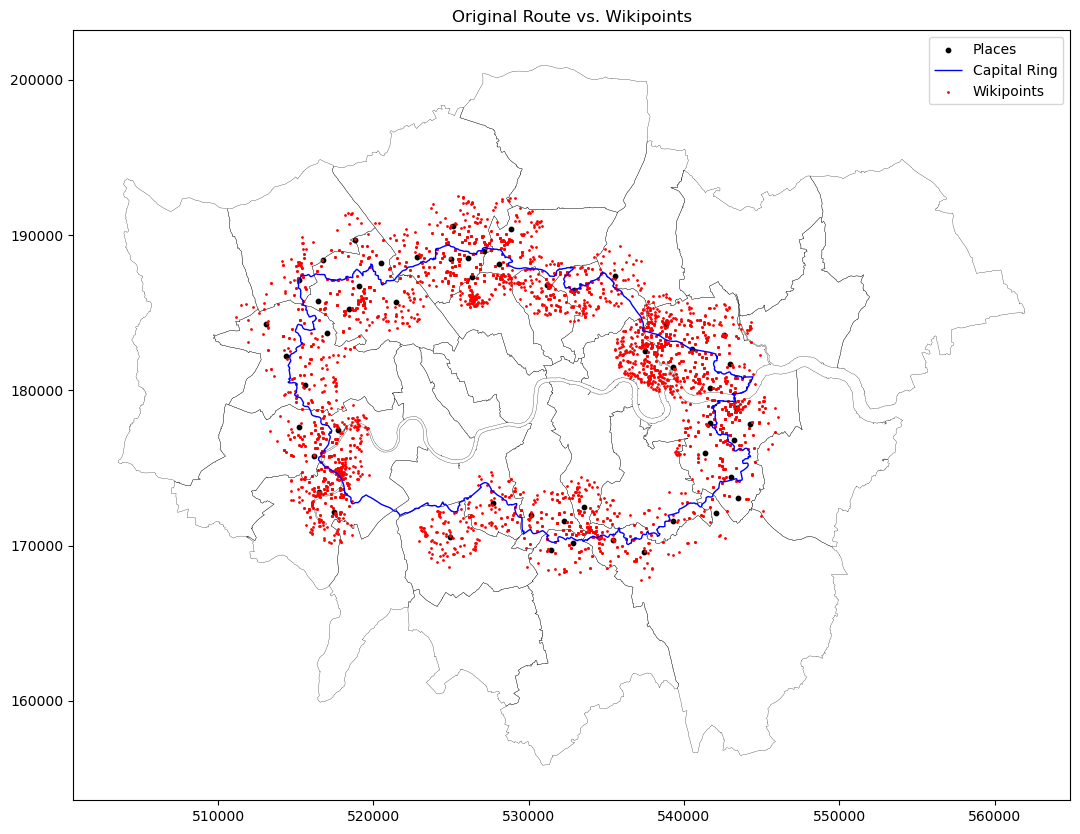

In [166]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(20, 10))
places_gdf.plot(ax=ax, color='black', markersize=10, label="Places")
capital_ring_line.plot(ax=ax, color='blue', linewidth=1, label="Capital Ring")
boro_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.2, label="City of London")
wiki_gdf.plot(ax=ax, color='red', markersize=1, label="Wikipoints")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Wikipoints")
plt.show()

In [167]:
wiki_gdf

,pageid,ns,title,lat,lon,dist,primary,place_index,geometry
0,51894002,0,"St Michael and All Angels Church, Beckton Road",51.515647,0.060587,123.8,,0,POINT (543074.041 181648.289)
1,696898,0,Beckton DLR station,51.514200,0.061600,264.1,,0,POINT (543148.858 181489.364)
2,15480979,0,Kingsford Community School,51.514300,0.055700,274.8,,0,POINT (542739.185 181488.97)
3,872221,0,Beckton,51.514600,0.067300,602.4,,0,POINT (543543.085 181544.998)
4,51847588,0,"St Mary Magdalene's Church, East Ham",51.522249,0.058783,714.0,,0,POINT (542928.225 182378.907)
...,...,...,...,...,...,...,...,...,...
4233,1585924,0,Woolwich Dockyard railway station,51.491300,0.053600,1930.0,,53,POINT (542665.289 178927.293)
4234,38950594,0,Ark Greenwich Free School,51.471860,0.052700,1945.1,,53,POINT (542663.434 176763.815)
4235,8961233,0,Woolwich Crown Court,51.496700,0.090000,1957.1,,53,POINT (545174.896 179599.297)
4236,66768333,0,"St Mary's Church, Welling",51.466394,0.092021,1979.2,,53,POINT (545411.521 176233.302)


The points are too close to each other. We need to perfom cluster analysis to determine, which points are part of which place. We observe:
- The route goes through places with different number of wikipoints;
- There are some outliers;
- The clusters for a place could be irregularly-shaped, because they are affected by the real-world conditions;
- We can approximate the number of clusters, however,
- The points are arranged around the place point, but there are many overlaps, and
- There may be points with little or no wikipoints.

The tested clustering techniques included hdbscan, k-means with forced N of clusters, and Voronoi-Based Clustering. The latter proved to most accurately separate wikipoints between places. Although this doesn't take into account densities, we could argue that someone who vitist the place might want to understand/see the whole area, and is not constrained by having to walk under 1km.

In [168]:
from scipy.spatial import Voronoi, KDTree

place_coords = np.array([[p.x, p.y] for p in places_gdf.geometry])
wiki_coords = np.array([[p.x, p.y] for p in wiki_gdf.geometry])

# Assign each wikipoint to the nearest place using a KDTree
tree = KDTree(place_coords)
_, nearest_place = tree.query(wiki_coords)

wiki_gdf["cluster"] = nearest_place  # Assign cluster based on nearest place index


In [169]:
wiki_gdf['cluster'].value_counts()

cluster
34    260
42    205
20    189
32    161
33    153
48    143
4     138
35    136
3     122
31    121
18    115
43    107
49    105
8     102
37    101
30     98
5      95
1      95
50     93
39     85
25     82
41     82
44     81
19     75
21     68
22     62
17     62
24     62
11     60
6      59
9      58
38     58
2      58
29     54
36     53
0      51
13     50
28     49
47     45
10     43
53     41
26     39
15     36
12     34
40     33
16     32
14     32
23     29
27     29
45     24
51     22
7      22
46     17
52     12
Name: count, dtype: int64

In [170]:
wiki_gdf

,pageid,ns,title,lat,lon,dist,primary,place_index,geometry,cluster
0,51894002,0,"St Michael and All Angels Church, Beckton Road",51.515647,0.060587,123.8,,0,POINT (543074.041 181648.289),0
1,696898,0,Beckton DLR station,51.514200,0.061600,264.1,,0,POINT (543148.858 181489.364),0
2,15480979,0,Kingsford Community School,51.514300,0.055700,274.8,,0,POINT (542739.185 181488.97),0
3,872221,0,Beckton,51.514600,0.067300,602.4,,0,POINT (543543.085 181544.998),0
4,51847588,0,"St Mary Magdalene's Church, East Ham",51.522249,0.058783,714.0,,0,POINT (542928.225 182378.907),0
...,...,...,...,...,...,...,...,...,...,...
4233,1585924,0,Woolwich Dockyard railway station,51.491300,0.053600,1930.0,,53,POINT (542665.289 178927.293),32
4234,38950594,0,Ark Greenwich Free School,51.471860,0.052700,1945.1,,53,POINT (542663.434 176763.815),29
4235,8961233,0,Woolwich Crown Court,51.496700,0.090000,1957.1,,53,POINT (545174.896 179599.297),53
4236,66768333,0,"St Mary's Church, Welling",51.466394,0.092021,1979.2,,53,POINT (545411.521 176233.302),53


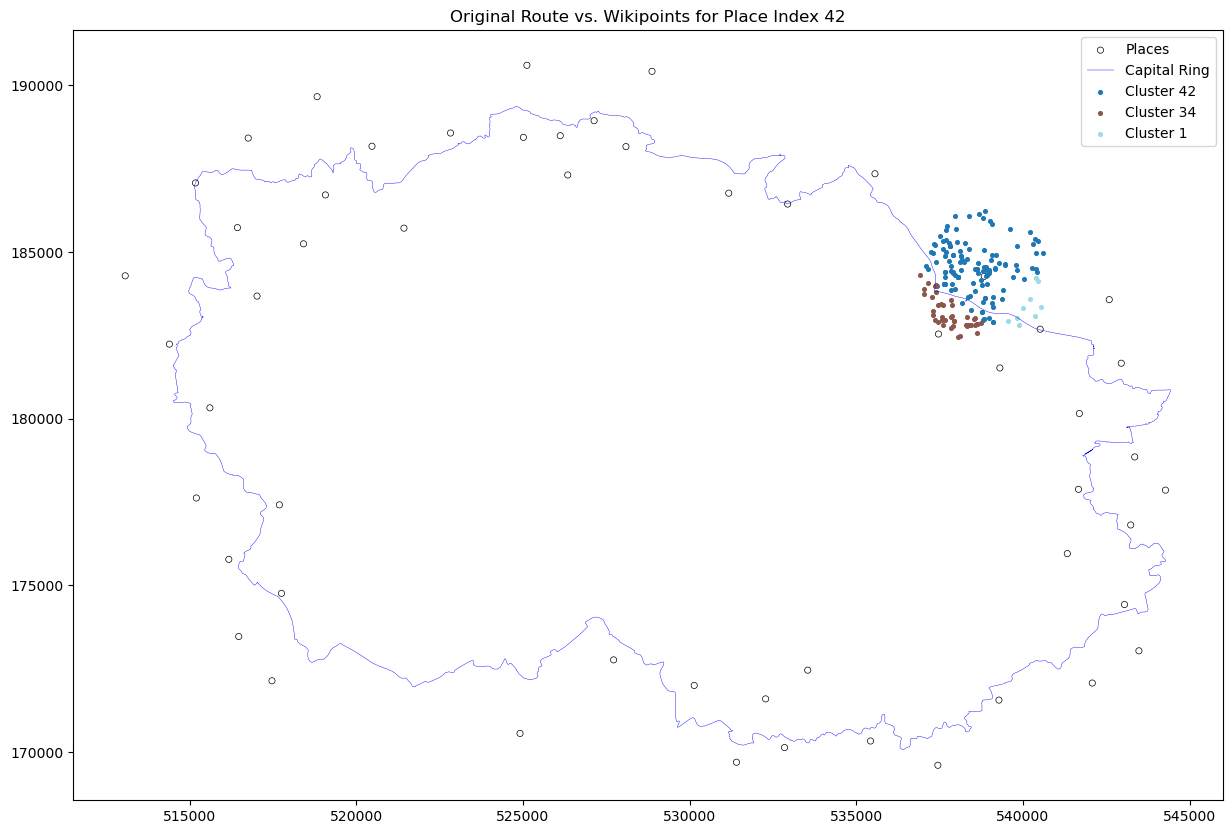

In [171]:
#________________________________________________________________________________________________________________
#Testing the clusters
#________________________________________________________________________________________________________________

# Initialize the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot places_gdf points
places_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, markersize=20, label="Places")

# Plot the Capital Ring Line
capital_ring_line.plot(ax=ax, color='blue', linewidth=0.3, label="Capital Ring")

# Set a random place_index
random_state = random.randint(0, 79)

# Get the matching rows for the selected place_index
matching_wiki_points = wiki_gdf[wiki_gdf['place_index'] == random_state]

# Generate a color map based on the unique clusters of these points
unique_clusters = matching_wiki_points['cluster'].unique()
colormap = plt.get_cmap('tab20', len(unique_clusters))  # Generate distinct colors for each cluster

# Plot the matching wikipoints
for cluster in unique_clusters:
    # Get the cluster points
    cluster_points = matching_wiki_points[matching_wiki_points['cluster'] == cluster]
    
    # Set color based on cluster or black for outliers
    if cluster != -1:  # Non-outliers
        cluster_color = colormap(unique_clusters.tolist().index(cluster))
        cluster_points.plot(ax=ax, color=cluster_color, markersize=7, label=f"Cluster {cluster}")
    else:  # Outliers
        cluster_points.plot(ax=ax, color='black', markersize=1, label="Outliers")

# Highlight all matching wikipoints for the selected place_index
#matching_wiki_points.plot(ax=ax, color='red', markersize=5, label="Wikipoints")

# Final adjustments and plot settings
ax.set_aspect('equal')
plt.legend()
plt.title(f"Original Route vs. Wikipoints for Place Index {random_state}")
plt.show()

In [247]:
#________________________________________________________________________________________________________________
#For each cluster, we remove overlapping points
#________________________________________________________________________________________________________________

print("Original wiki_gdf length:", len(wiki_gdf))
deduped_rows = []

for cluster, group in wiki_gdf.groupby("cluster"):
    # Drop duplicates within group
    group_deduped = group.drop_duplicates(subset=['geometry'], keep='first')
    deduped_rows.append(group_deduped)

wiki_gdf_dedupped = gpd.GeoDataFrame(pd.concat(deduped_rows, ignore_index=True))
print("Deduplicated wiki_gdf length:", len(wiki_gdf_dedupped))

Original wiki_gdf length: 1668
Deduplicated wiki_gdf length: 1082


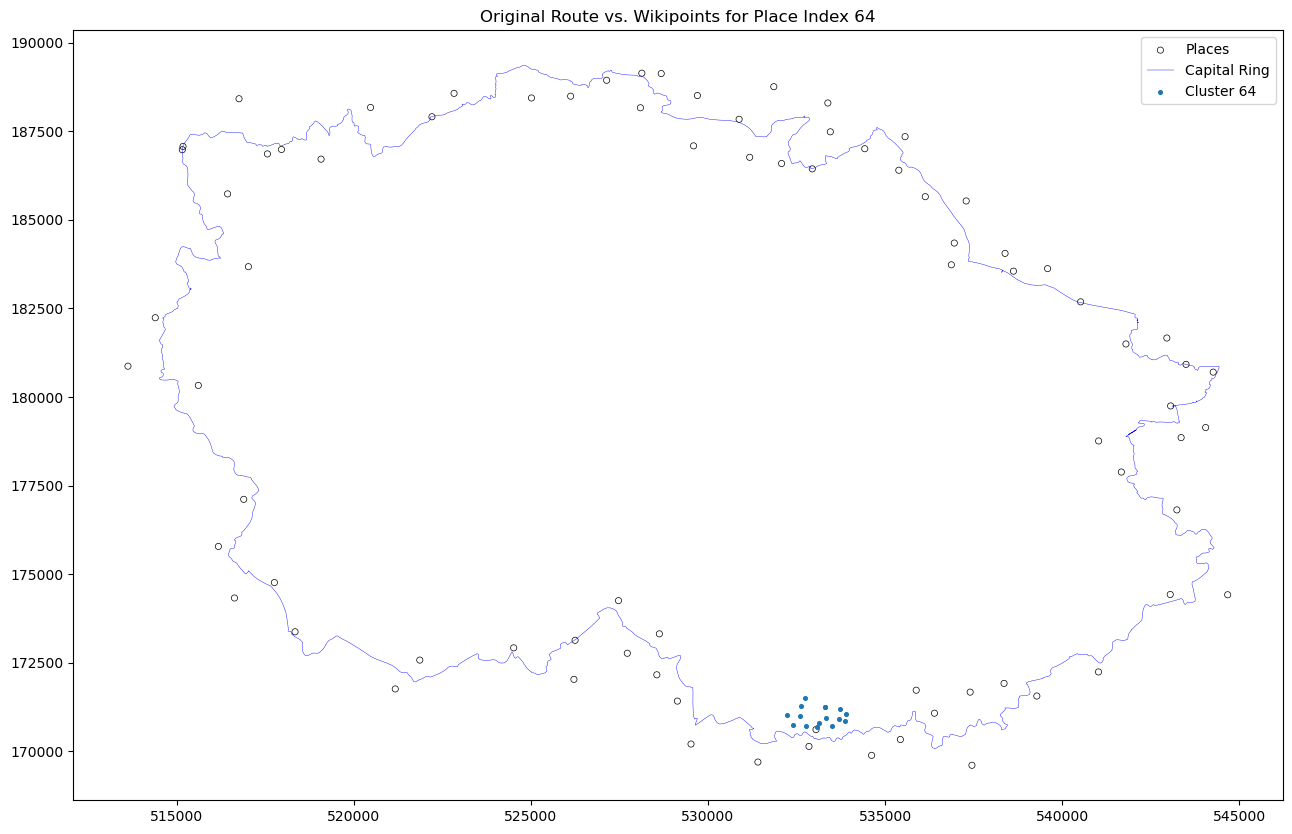

In [253]:
#________________________________________________________________________________________________________________
#Testing that the sorting by 'cluster' column works as intended.
#The value of this column corresponds to the index of the places_gdf
#________________________________________________________________________________________________________________

# Initialize the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot places_gdf points
places_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, markersize=20, label="Places")

# Plot the Capital Ring Line
capital_ring_line.plot(ax=ax, color='blue', linewidth=0.3, label="Capital Ring")

# Set a random place_index
random_state = random.randint(0, 79)

# Get the matching rows for the selected place_index
matching_wiki_points = wiki_gdf_dedupped[wiki_gdf_dedupped['cluster'] == random_state]

# Generate a color map based on the unique clusters of these points
unique_clusters = matching_wiki_points['cluster'].unique()
colormap = plt.get_cmap('tab20', len(unique_clusters))  # Generate distinct colors for each cluster

# Plot the matching wikipoints
for cluster in unique_clusters:
    # Get the cluster points
    cluster_points = matching_wiki_points[matching_wiki_points['cluster'] == cluster]
    
    # Set color based on cluster or black for outliers
    if cluster != -1:  # Non-outliers
        cluster_color = colormap(unique_clusters.tolist().index(cluster))
        cluster_points.plot(ax=ax, color=cluster_color, markersize=7, label=f"Cluster {cluster}")
    else:  # Outliers
        cluster_points.plot(ax=ax, color='black', markersize=1, label="Outliers")

# Highlight all matching wikipoints for the selected place_index
#matching_wiki_points.plot(ax=ax, color='red', markersize=5, label="Wikipoints")

# Final adjustments and plot settings
ax.set_aspect('equal')
plt.legend()
plt.title(f"Original Route vs. Wikipoints for Place Index {random_state}")
plt.show()

In [462]:
wiki_gdf_dedupped['wiki_link'] = None
for index, row in wiki_gdf_dedupped.iterrows():
    wiki_gdf_dedupped['wiki_link'][index] = 'https://en.wikipedia.org/?curid=' + str(row['pageid'])

In [464]:
wiki_gdf_dedupped.head(2)

,pageid,ns,title,lat,lon,dist,primary,place_index,geometry,cluster,wiki_link
0,353306,0,Woolwich foot tunnel,51.49879,0.06165,144.9,,0,POINT (543200.622 179775.886),0,https://en.wikipedia.org/?curid=353306
1,8609500,0,North Woolwich railway station,51.49940,0.06230,209.1,,0,POINT (543243.823 179844.989),0,https://en.wikipedia.org/?curid=8609500


In [ ]:
#________________________________________________________________________________________________________________
#This section will include parsing the text and categories from chat GPT API
#For now I will create columns with placeholder words
#________________________________________________________________________________________________________________


In [467]:
wiki_gdf_dedupped['wiki_headline'] = "lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua"
wiki_gdf_dedupped['wiki_categories'] = "royal, riverside, history"

In [468]:
places_gdf['place_headline'] = "lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua"
places_gdf['place_categories'] = "royal, riverside, history"

In [473]:
#Reprojecting gdf for mapbox
places_gdf_wgs84 = places_gdf.to_crs(4258)
print(places_gdf_wgs84.crs)
print(places_gdf_wgs84.iloc[2]["geometry"]) #ensuring the coordinates have transformed
places_gdf_wgs84.to_file("data/places_wgs84.geojson", driver="GeoJSON") 

EPSG:4258
POINT (0.0772798084689046 51.50684263876633)


In [460]:
#wiki_cat_df['wiki_link']

In [ ]:
#________________________________________________________________________________________________________________
#Section below parses the categories and performs topic modelling with the output
#________________________________________________________________________________________________________________


In [465]:
# import re
# import nltk
# import spacy
# from sklearn.feature_extraction.text import TfidfVectorizer
# from collections import Counter
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# from bertopic import BERTopic
# from gensim.corpora import Dictionary
# from gensim.models import LdaModel

# nltk.download('stopwords')
# nltk.download('wordnet')
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# import re
# import spacy
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from collections import Counter
# from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim.corpora import Dictionary
# from gensim.models import LdaModel
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# from bertopic import BERTopic



In [254]:
# """
#     parse.py
#     MediaWiki API Demos
#     Demo of `Parse` module: Parse content of a page
#     MIT License
# """

# wiki_cat = requests.Session()
# wiki_cat_url = "https://en.wikipedia.org/w/api.php"

In [451]:
# #________________________________________________________________________________________________________________
# #Trying the selected point - TEST
# #________________________________________________________________________________________________________________
# test_place_point_index = 49
# wikipoints_subset = wiki_gdf_dedupped[wiki_gdf_dedupped['cluster'] == test_place_point_index].reset_index(drop=True)
# wiki_cat_df = pd.DataFrame()

In [459]:
# for index,row in wikipoints_subset.iterrows():
#     pageid = row['pageid']
#     wiki_cat_params = {
#         "action": "parse",
#         "pageid": pageid,
#         "prop": "categories",
#         "format": "json"
#     }
    
#     R = wiki_cat.get(url=wiki_cat_url, params=wiki_cat_params)
#     full_url = wiki_cat_url + "?" + "&".join([f"{key}={value}" for key, value in wiki_cat_params.items()])
#     print("Requesting URL:", full_url)
    
#     if R.status_code == 200:
#         data = R.json()
#         results = data.get("parse")   

#         if results:
#             df = pd.json_normalize(results)
#             wiki_cat_df = pd.concat([wiki_cat_df, df], ignore_index=True)
#     else:
#         print(f"Error: {R.status_code} - {R.text}")

In [455]:
# wiki_cat_df["categories_unpacked"] = None

In [456]:
# for index,row in wiki_cat_df.iterrows():
#     cat_list = []
#     for i in row["categories"]:
#         if isinstance(i, dict) and 'hidden' not in i.keys():
#             cat_list.append(i["*"])
#     wiki_cat_df["categories_unpacked"][index] = cat_list
#     print(f"Categories are: {cat_list}")

In [457]:
# wiki_cat_df

In [419]:
# nlp = spacy.load("en_core_web_sm")

In [421]:
# # Sample dataset
# texts = []
# for i in wiki_cat_df["categories_unpacked"]:
#     texts = texts + i

In [429]:
# texts = ['Bridges_in_London', 'Bridges_completed_in_1933', 'Transport_in_the_London_Borough_of_Richmond_upon_Thames', 
#          'Bridges_across_the_River_Thames', 'Road_bridges_in_England', 'Grade_II*_listed_bridges_in_London', 
#          'Grade_II*_listed_buildings_in_the_London_Borough_of_Richmond_upon_Thames']

In [458]:
# # Exclude words list
# exclude_words = {'london', 'england', 'richmond', 'thames', 'borough', 'united', 'kingdom',
#                  'history', 'building', 'structure', 'upon', 'establishment', 'grade','listed', 'completed', 'defunct', 'stub'}

# # Preprocessing function
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# def preprocess(text):
#     # Replace underscores with spaces and remove numbers
#     text = text.replace('_', ' ')  
#     text = re.sub(r'\d+', '', text)  # Remove digits
#     text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation (except spaces)
    
#     # Split the text into words
#     words = text.lower().split()

#     # Lemmatize and filter stopwords and exclude words
#     processed_words = []
#     for word in words:
#         lemmatized_word = lemmatizer.lemmatize(word)
#         if lemmatized_word not in stop_words and lemmatized_word not in exclude_words:
#             processed_words.append(lemmatized_word)

#     return ' '.join(processed_words)

# # Apply preprocessing to all texts
# processed_texts = [preprocess(text) for text in texts]

# ### Step 2: Extract Key Concepts

# ## TF-IDF for Keyword Extraction
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(processed_texts)
# feature_names = vectorizer.get_feature_names_out()
# tfidf_scores = X.toarray().sum(axis=0)
# keywords = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)

# print("\nTop Keywords (TF-IDF):")
# print([word for word, score in keywords[:10]])

# ## Named Entity Recognition (NER) with spaCy
# nlp = spacy.load("en_core_web_sm")

# entities = []
# for text in processed_texts:
#     doc = nlp(text)
#     entities.extend([(ent.text, ent.label_) for ent in doc.ents])

# print("\nNamed Entities (NER):")
# print(entities)

# ## Topic Modeling with LDA
# tokenized_texts = [text.split() for text in processed_texts]
# dictionary = Dictionary(tokenized_texts)
# corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# lda_model = LdaModel(corpus, num_topics=2, id2word=dictionary, passes=10)
# topics = lda_model.print_topics()
# print("\nLDA Topics:")
# for topic in topics:
#     print(topic)

# ## BERTopic for More Advanced Topic Modeling
# topic_model = BERTopic()
# topics, probs = topic_model.fit_transform(processed_texts)
# print("\nBERTopic Topics:")
# print(topic_model.get_topic_info())

# ### Step 3: Summarize and Visualize
# ## Word Cloud for Visualization
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(processed_texts))
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()